In [1]:
import numpy as np
import torch 
from torch import optim, softmax
import torch.nn as nn 
import scipy
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import tqdm as tqdm
from tqdm import *
import seaborn

In [2]:
from training import double_train, x
from utils import affine_transformation, gaussian_icdf, gmm_2modes_icdf, quadratic, quartic
from plot_helpers import params_recovery, loss_fit

## PARAMS; GMM ICDF; QUADRATIC; ENTROPY

In [35]:
sampled_gen = []
for _ in tqdm(range(50000)):
    eps = G.simulate()
    sampled_gen.append(G.noise_to_x(eps).detach().numpy().item())

100%|██████████| 50000/50000 [00:10<00:00, 4942.11it/s]


In [36]:
xmin = -15
xmax = 15
xx = torch.Tensor(np.linspace(xmin,xmax,1000))
Z = torch.mean(torch.exp(logd(xx))) * (xmax - xmin) 

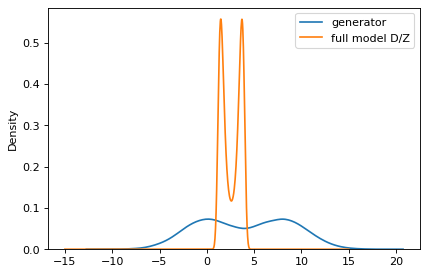

In [37]:
fig, ax = plt.subplots()
seaborn.kdeplot(np.hstack(sampled_gen), label='generator') #kernel density plot 
ax.plot(xx, (torch.exp(logd(xx))/Z).detach().numpy(), label ='full model D/Z')
ax.legend()
fig.set_dpi(80)

In [6]:
G = gmm_2modes_icdf()
D = quadratic(3, 1) #change init to check robustness 
learning_rate = 1e-4
epochs= 500000
entropy = True

In [7]:
def double_train_multi(x, G, D, learning_rate, epochs, entropy):
    logd = D.logd
    lg=[]
    ld=[]
    optimizer_D=optim.Adam([D.mu_k, D.log_sigma_k], lr=learning_rate)
    optimizer_G=optim.Adam([G.mu_q, G.log_sigma_q, G.weights],lr=learning_rate)
    for param in G.parameters():
        param.requires_grad = True
    for param in D.parameters():
        param.requires_grad = True
        
    for epoch in tqdm(range(epochs)):
        eps = G.simulate()
        x_ = G.noise_to_x(eps)
        
        ##### DISCRIMINATOR'S TRAINING #####
        
        optimizer_D.zero_grad()
        loss_D = - torch.mean(logd(x)) + torch.mean(logd(x_))
        loss_D.backward(retain_graph=True)
        optimizer_D.step()

        ld.append(loss_D.item())
        
        #define q (entropy)
        q = torch.distributions.Normal(G.mu_q, torch.exp(G.log_sigma_q))
        
        ##### GENERATOR'S TRAINING #####
        
        optimizer_G.zero_grad()
        loss_G = - torch.mean(logd(x_)) + torch.mean(G.logprob(x_))
        loss_G.backward(retain_graph=True)
        optimizer_G.step()
        
        lg.append(loss_G.item())
        
       # if epoch%400==0 or epoch == (epochs-1) :
       #     sampled_gen = []
       #     for _ in range(1000):
       #         eps = G.simulate()
       #         sampled_gen.append(G.noise_to_x(eps).detach().numpy().item())
        
       #     xmin = -10
       #     xmax = 20
       #     xx = torch.Tensor(np.linspace(xmin,xmax,1000))
       #     Z = torch.mean(torch.exp(D.logd(xx))) * (xmax - xmin) 

        #    fig, ax = plt.subplots()
        #   seaborn.kdeplot(np.hstack(sampled_gen), label='generator', color = 'slateblue') #kernel density plot 
        #    ax.plot(xx, (torch.exp(D.logd(xx))/Z).detach().numpy(), label ='full model D/Z', color = 'darksalmon')
        #    ax.legend()
        #    fig.set_dpi(70)
        #    fig.show()

        #logZ = log_quadrature(logd, xmin, xmax, it)
        #lb = lower_bound_torch(logd, G, optimizer_G, 0, it)
        #print('lb=',lb.item(), 'logZ=',logZ.item())
        #print(D.theta1, D.theta2, D.theta3, D.theta4)

        #plt.figure()
        #plt.plot(xx, (torch.exp(logd(xx)-lb)).detach().numpy(), label = 'D/approx_Z')
        #seaborn.kdeplot(np.hstack(x), label='data') 
        #plt.legend()
        #plt.show()

    return lg, ld

In [8]:
lg, ld = double_train_multi(x, G, D, learning_rate, epochs, entropy)

  0%|          | 0/500000 [00:00<?, ?it/s]/mnt/nfs/home/i.sebag/PWGAN2/utils.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_weights = F.softmax(self.weights)
/mnt/nfs/home/i.sebag/PWGAN2/utils.py:83: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_weights = F.softmax(self.weights)
100%|██████████| 500000/500000 [14:49<00:00, 561.82it/s]


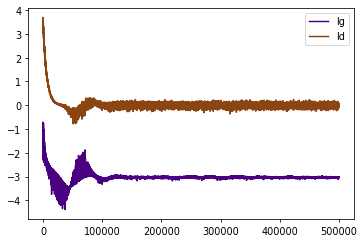

In [9]:
fig, ax = plt.subplots()
plt.plot(np.convolve(lg,np.ones(10)/10)[10:len(lg)-10], label = 'lg', color = 'indigo')
plt.plot(np.convolve(ld,np.ones(100)/100)[100:len(ld)-100], label = 'ld', color = 'saddlebrown')
fig.set_dpi(70)
plt.legend()
plt.show()

In [10]:
sampled_gen = []
for _ in tqdm(range(100000)):
    eps = G.simulate()
    sampled_gen.append(G.noise_to_x(eps).detach().numpy().item())

  0%|          | 0/100000 [00:00<?, ?it/s]/mnt/nfs/home/i.sebag/PWGAN2/utils.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_weights = F.softmax(self.weights)
100%|██████████| 100000/100000 [00:19<00:00, 5099.96it/s]


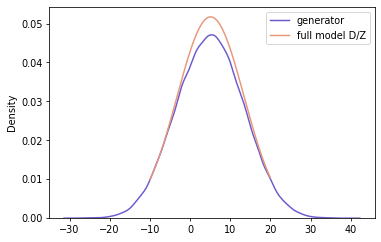

In [14]:
xmin = -10
xmax = 20
xx = torch.Tensor(np.linspace(xmin,xmax,1000))
Z = torch.mean(torch.exp(D.logd(xx))) * (xmax - xmin) 

fig, ax = plt.subplots()
seaborn.kdeplot(np.hstack(sampled_gen), label='generator', color = 'slateblue') #kernel density plot 
ax.plot(xx, (torch.exp(D.logd(xx))/Z).detach().numpy(), label ='full model D/Z', color = 'darksalmon')
ax.legend()
fig.set_dpi(70)

## Training of the quartic discriminator only 

In [3]:
G = gmm_2modes_icdf()
D = quartic() 
learning_rate = 1e-4
epochs= 500000
entropy=True

In [4]:
def train_discr(G, D, learning_rate, epochs, entropy=True):

    logd = D.logd
    ld=[]
    optimizer_D=optim.Adam([D.theta1, D.theta2, D.theta3, D.theta4], lr=learning_rate)

    for param in D.parameters():
        param.requires_grad = True 

    for _ in tqdm(range(epochs)):

        eps = G.simulate()
        x_ = G.noise_to_x(eps)
    
        #### DISCRIMINATOR'S TRAINING ####

        optimizer_D.zero_grad()
        loss_D = - torch.mean(logd(x)) + torch.mean(logd(x_))
        loss_D.backward(retain_graph=True)
        optimizer_D.step()

        ld.append(loss_D.item())
       
    return ld

In [5]:
ld = train_discr(G, D, learning_rate, epochs, entropy)

  0%|          | 0/500000 [00:00<?, ?it/s]/mnt/nfs/home/i.sebag/PWGAN2/utils.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_weights = F.softmax(self.weights)
100%|██████████| 500000/500000 [07:12<00:00, 1156.01it/s]


In [6]:
sampled_gen = []
for _ in tqdm(range(50000)):
    eps = G.simulate()
    sampled_gen.append(G.noise_to_x(eps).detach().numpy().item())

100%|██████████| 50000/50000 [00:10<00:00, 4908.21it/s]


In [8]:
xmin = -15
xmax = 15
xx = torch.Tensor(np.linspace(xmin,xmax,1000))
Z = torch.mean(torch.exp(D.logd(xx))) * (xmax - xmin) 

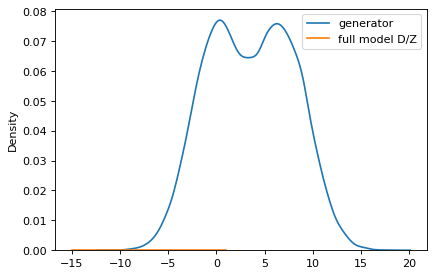

In [10]:
fig, ax = plt.subplots()
seaborn.kdeplot(np.hstack(sampled_gen), label='generator') #kernel density plot 
ax.plot(xx, (torch.exp(D.logd(xx))/Z).detach().numpy(), label ='full model D/Z')
ax.legend()
fig.set_dpi(80)